# Roche lobe effects

## Adapted from the `p-winds` tutorial `tidal_effects`

MGS / Feb 16, 2023

In this notebook we explore the Roche lobe effects in one-dimensional Parker wind models for exospheres of hot exoplanets. These effects were notably discussed in [Erkaev et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007A%26A...472..329E/abstract), and were implemented in `p-winds` [version 1.3.0](https://github.com/ladsantos/p-winds/releases/tag/v1.3.0).

The process of including the Roche lobe (or tidal) effects in `p-winds` models is simple, and it involves changing how the radius at the sonic point and outflow structure are calculated.

We start by importing all the necessary packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium, transit, lines

# Uncomment the next line if you have a MacBook with retina screen
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

We are going to replicate the [quickstart example for HD 209458 b](https://p-winds.readthedocs.io/en/latest/quickstart.html) and include the tidal effects. We will assume that the planet has an isothermal upper atmosphere with temperature of $9\,100$ K and a total mass loss rate of $2 \times 10^{10}$ g s$^{-1}$ based on the results from [Salz et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...586A..75S/abstract). We will also assume: 
* The atmosphere is made up of only H and He
* The H number fraction is $0.9$
* Initially a fully neutral atmosphere (this is going to be self-consistently calculated later).

We will also need to know other parameters, namely: the stellar mass and radius, and the semi-major axis of the orbit.

In [3]:
# HAT-P-67 b planetary parameters, measured
R_pl = 2.085  # Planetary radius in Jupiter radii
M_pl = 0.34  # Planetary mass in Jupiter masses
impact_parameter = 0.04  # Transit impact parameter
a_pl = 0.065  # Orbital semi-major axis in astronomical units

# HAT-P-67 b stellar parameters
R_star = 2.546  # Stellar radius in solar radii
M_star = 1.642  # Stellar mass in solar masses

In [4]:
#m_dot = M_pl*u.Mjup/(13.6*u.Gyr)
m_dot = M_pl*u.Mjup/(20*u.Gyr)
m_dot = m_dot.to(u.g/u.s)
m_dot

<Quantity 1.02251496e+12 g / s>

In [5]:
# A few assumptions about the planet's atmosphere
m_dot = m_dot.value   # Total atmospheric escape rate in g / s
T_0 = 9_100  # Wind temperature in K
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

Next, we retrieve the high-energy spectrum of the host star with fluxes at the planet. For this example, we use the solar spectrum for convenience.

In [6]:
from gollum.phoenix import PHOENIXSpectrum

In [22]:
omega

<Quantity 0.1042397 sr>

In [7]:
stellar_spec = PHOENIXSpectrum(teff=6400, logg=3.5, wl_lo=1, wl_hi=10_000)
flux_density = stellar_spec.flux.to(u.erg/u.s/(u.cm**2)/u.Angstrom)/(np.pi*u.steradian) # convert to erg/cm^2/s/A/steradian

omega = np.pi*(R_star*u.Rsun)**2/(a_pl*u.AU)**2
omega = omega.to(u.steradian, equivalencies=u.dimensionless_angles())
flux_at_planet_surface = flux_density * omega

spectrum_F ={'wavelength':stellar_spec.wavelength.value,
           'flux_lambda':flux_at_planet_surface.value,
           'wavelength_unit':u.Angstrom,
           'flux_unit':flux_at_planet_surface.unit}

## Read in Sanz-Forcada et al. 2011 $\tau$ Boo spectrum

It's an F7, so a bit cooler than our F5, but close enough?  The units of the file are (photons/s/cm^2/bin).  We have to convert...

In [23]:
import pandas as pd

In [ ]:
! mv 

In [24]:
! head -n 3 ../../data/literature/sanz_forcada2011/tauboo_simulspec.dat

wavelength (A) flux (photons) 
  1.0050e+00   9.6429e-11 
  1.0150e+00   1.0040e-10 


In [ ]:
from specutils import Spectrum1D

In [100]:
df_F7 = pd.read_csv('../../data/literature/sanz_forcada2011/tauboo_simulspec.dat', comment='<', 
                    engine='python', sep='   ', skiprows=1, names=['wl_Angs', 'flux_photons'])

In [103]:
spec_F7 = Spectrum1D(flux=df_F7.flux_photons.values*u.photon/u.s/u.cm**2, 
                     spectral_axis=df_F7.wl_Angs.values*u.Angstrom)

In [104]:
spec_F7 = Spectrum1D(flux=spec_F7.energy.value \
                     * df_F7.flux_photons.values*u.eV/u.s/u.cm**2/u.Angstrom\
                     / np.diff(spec_F7.bin_edges.value) , 
                     spectral_axis=df_F7.wl_Angs.values*u.Angstrom)

In [105]:
spec_F7.flux.max()

<Quantity 29.89424989 eV / (Angstrom cm2 s)>

In [106]:
spec_F7.new_flux_unit(u.erg/u.s/u.cm**2/u.Angstrom).flux.max()

<Quantity 4.78958687e-11 erg / (Angstrom cm2 s)>

In [107]:
spec_F7 = spec_F7.new_flux_unit(u.erg/u.s/u.cm**2/u.Angstrom) 

That's apparently the flux we would observe at Earth?  Let's get luminosity and then get the flux at the planet...

In [108]:
spec_F7 = Spectrum1D(flux=spec_F7.flux*4*np.pi*(15.60*u.pc)**2, 
                     spectral_axis=df_F7.wl_Angs.values*u.Angstrom)

In [109]:
spec_F7 = spec_F7.new_flux_unit(u.erg/u.s/u.Angstrom) 

now convert to flux density seen at the planet...

In [110]:
spec_F7.flux.max()

<Quantity 1.39462744e+30 erg / (Angstrom s)>

In [111]:
spec_F7 = Spectrum1D(flux=spec_F7.flux/(4*np.pi*(0.065*u.AU)**2), 
                     spectral_axis=df_F7.wl_Angs.values*u.Angstrom)

In [112]:
spec_F7 = spec_F7.new_flux_unit(u.erg/u.s/u.cm**2/u.Angstrom) 

In [113]:
spec_F7.flux.max()

<Quantity 117373.70240524 erg / (Angstrom cm2 s)>

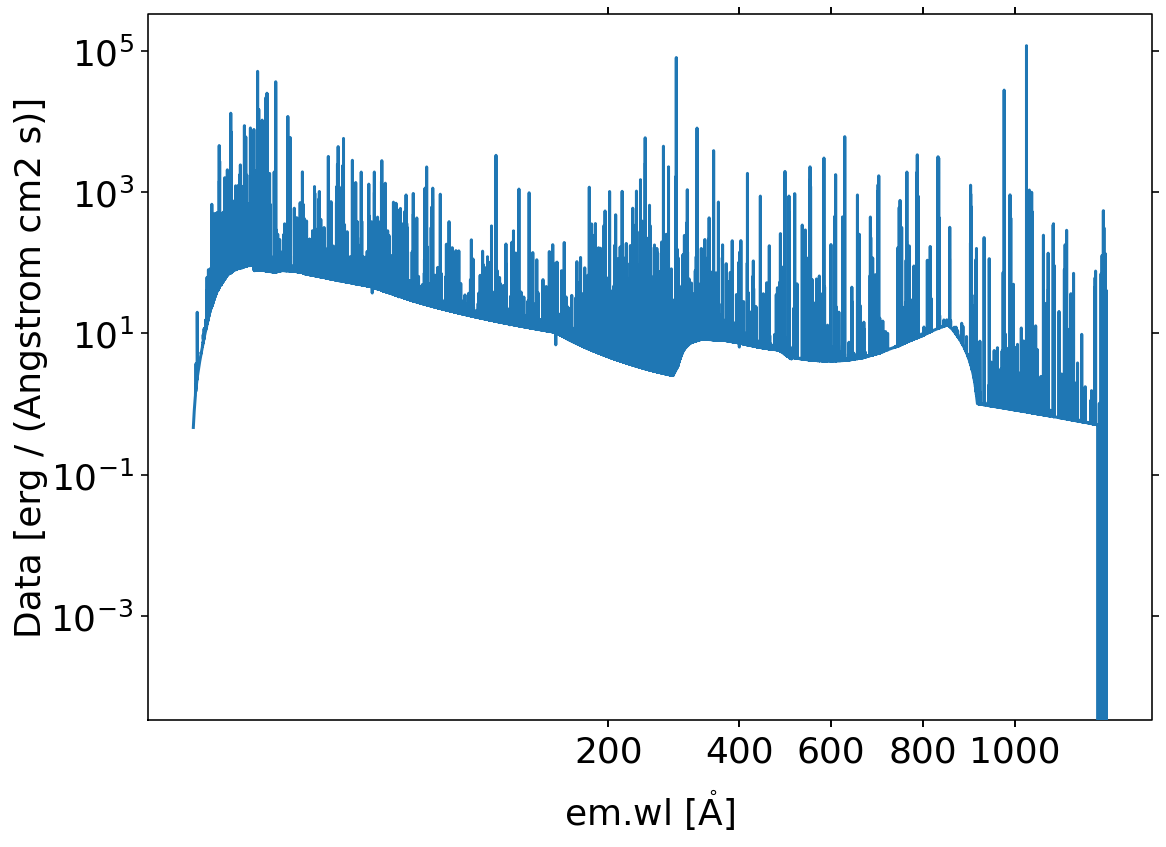

In [114]:
ax = spec_F7.plot()
ax.set_yscale('log')

In [121]:
L_F7 = np.trapz(spec_F7.flux, spec_F7.wavelength)

In [122]:
L_F7

<Quantity 46194.7505978 erg / (cm2 s)>

In [125]:
L_star = 3.1549454*10**9 * L_F7.unit

In [126]:
L_F7 / L_star

<Quantity 1.46420127e-05>

In [133]:
L_star

<Quantity 3.1549454e+09 erg / (cm2 s)>

In [134]:
(8.5*u.L_sun/(4.0*np.pi*(0.065*u.AU)**2 )).to(u.erg/u.s/u.cm**2)

<Quantity 2.73844141e+09 erg / (cm2 s)>

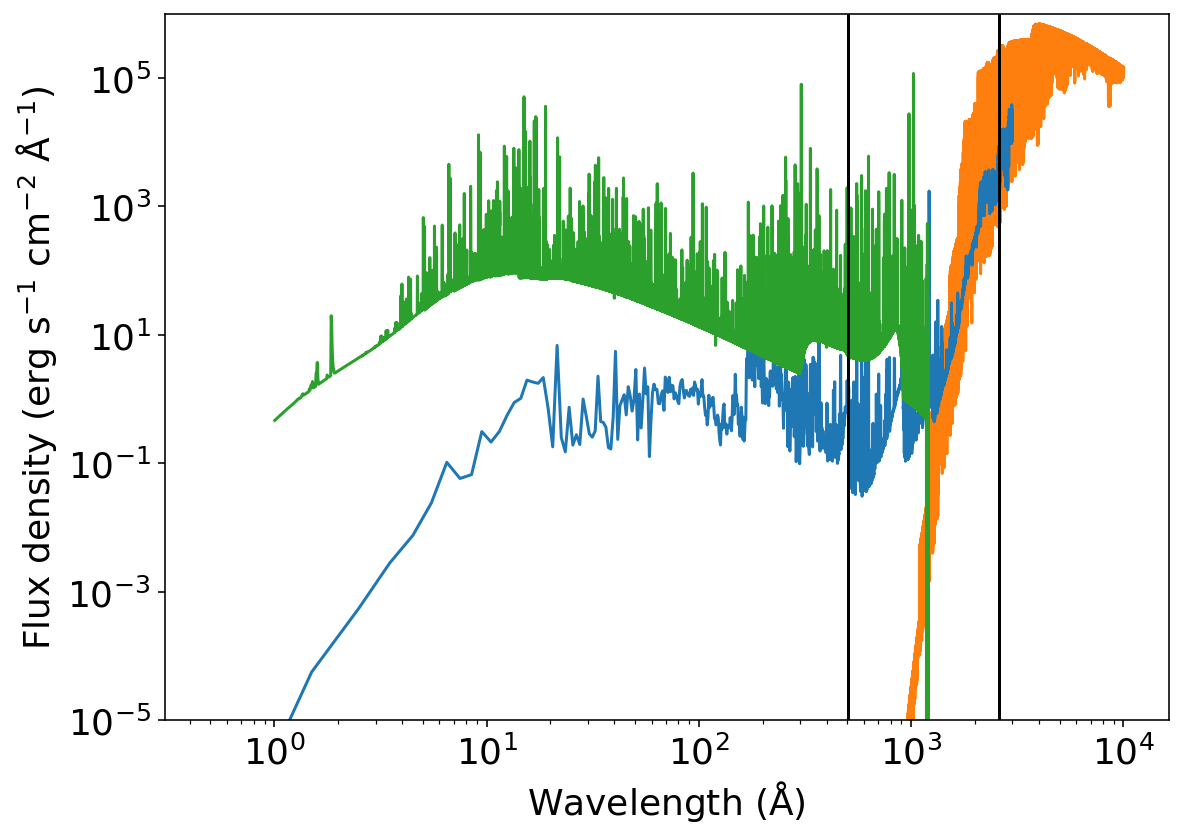

In [140]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('/Users/mag3842/GitHub/p-winds/data/solar_spectrum_scaled_lambda.dat',
                                    units)
plt.loglog(spectrum['wavelength'], spectrum['flux_lambda'])
plt.loglog(spectrum_F['wavelength'], spectrum_F['flux_lambda'], zorder=-1)
plt.ylim(1E-5, 1E6)
plt.xlabel(r'Wavelength (${\rm \AA}$)')

plt.plot(spec_F7.wavelength, spec_F7.flux*1)

plt.axvline(504, color='k')
plt.axvline(2600, color='k')

plt.xlim(100, )

plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

Now we can calculate the distribution of ionized/neutral hydrogen. And here is where things differ a bit to include the tidal effects. We need to specify what is the stellar mass and the semi-major axis of the planet.

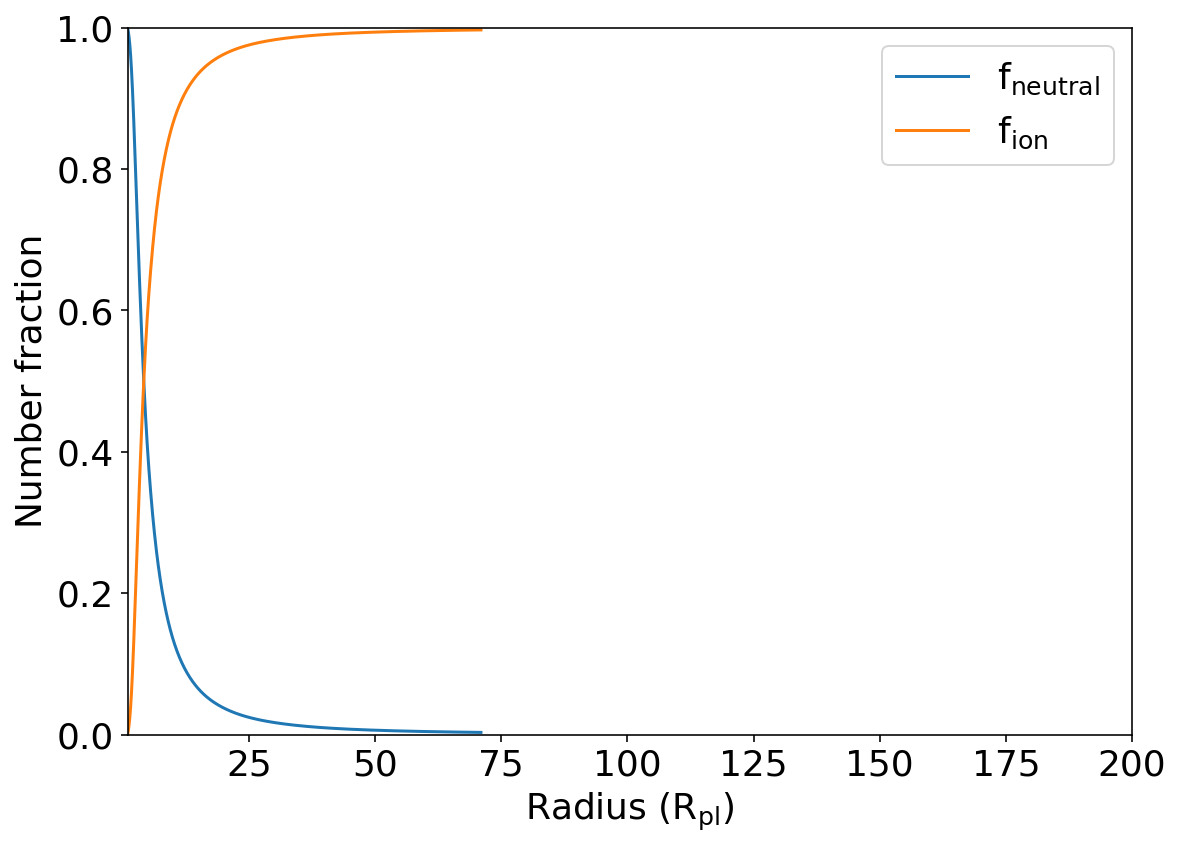

In [15]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(71), 500)  # Radial distance profile in unit of planetary radii

f_r, mu_bar = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
                            m_dot, M_pl, mu_0, star_mass=M_star, 
                            semimajor_axis=a_pl,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True)

f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number fraction')
plt.xlim(1, 200)
plt.ylim(0, 1)
plt.legend()
plt.show()

Instead of using the functions `parker.radius_sonic_point()` and `parker.structure()`, we use `parker.radius_sonic_point_tidal()` and `parker.structure_tidal()`. Their inputs are a bit different, but the outputs are the same. As before, the velocities and densities calculated by `parker.structure_tidal()` are measured in units of sound speed and density at the sonic point, respectively.

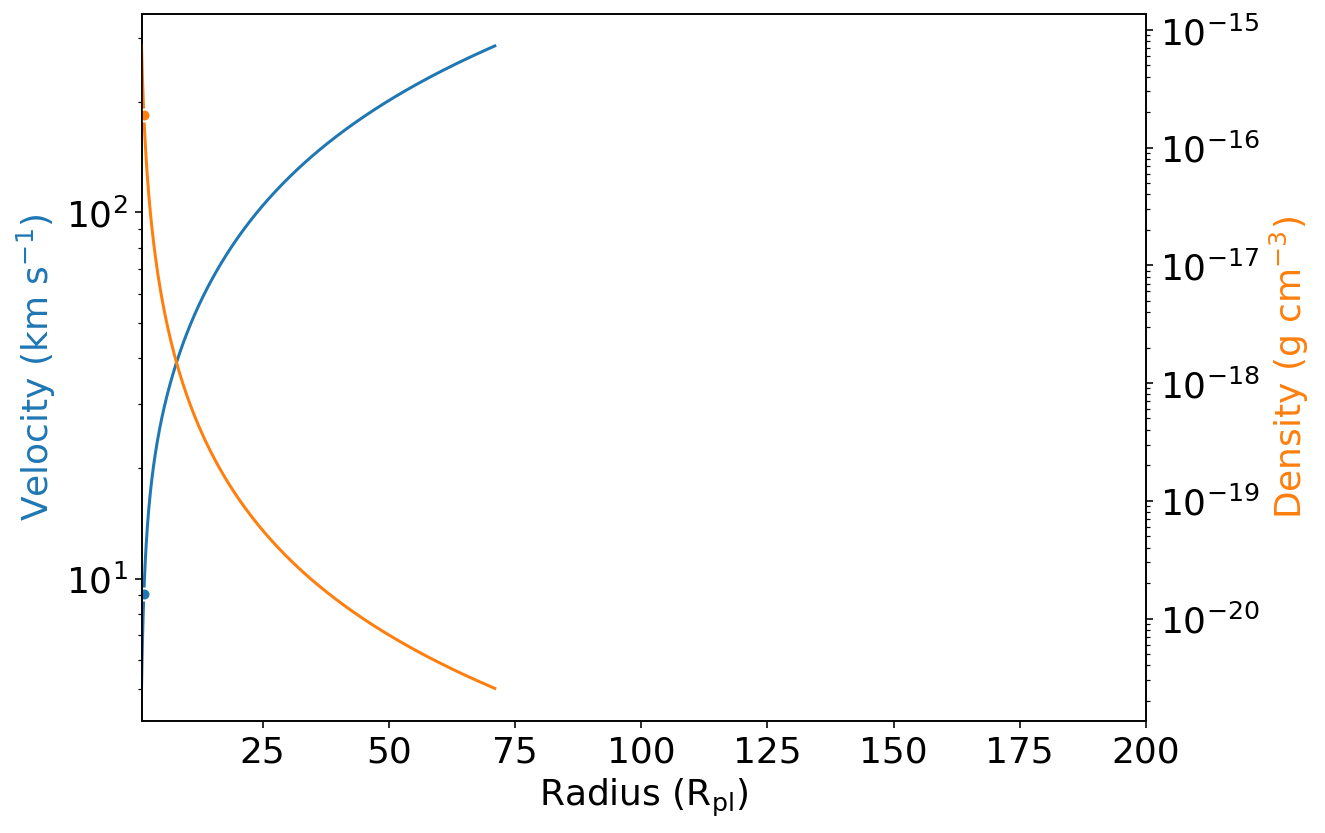

In [16]:
vs = parker.sound_speed(T_0, mu_bar)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point_tidal(M_pl, vs, M_star, a_pl)  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

r_array = r * R_pl / rs
v_array, rho_array = parker.structure_tidal(r_array, vs, rs, M_pl, M_star, a_pl)

# Convenience arrays for the plots
r_plot = r_array * rs / R_pl
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 200)
plt.show()

Let's compare the structure with and without tidal effects to see how they differ. We will plot the profiles with the effects implemented in full lines, and those without in dashed lines.

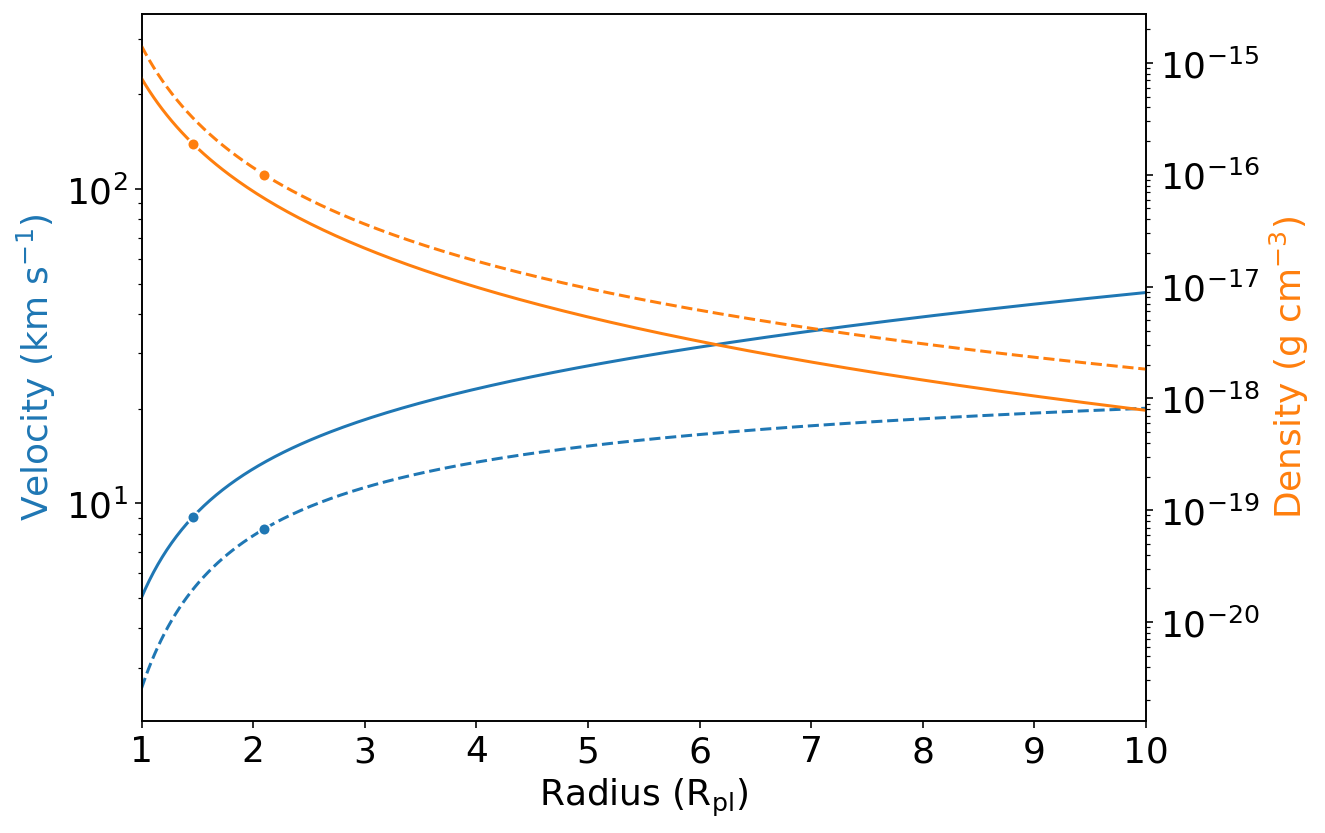

In [17]:
f_r_nte, mu_bar_nte = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
                            m_dot, M_pl, mu_0,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True)

vs_nte = parker.sound_speed(T_0, mu_bar_nte)  # Speed of sound (km/s, assumed to be constant)
rs_nte = parker.radius_sonic_point(M_pl, vs_nte)  # Radius at the sonic point (jupiterRad)
rhos_nte = parker.density_sonic_point(m_dot, rs_nte, vs_nte)  # Density at the sonic point (g/cm^3)

r_array_nte = r * R_pl / rs_nte
v_array_nte, rho_array_nte = parker.structure(r_array_nte)

# Convenience arrays for the plots
v_plot_nte = v_array_nte * vs_nte
rho_plot_nte = rho_array_nte * rhos_nte

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()

# With tidal effects
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1')

# No tidal effects
ax1.semilogy(r_plot, v_plot_nte, color='C0', ls='--')
ax1.plot(rs_nte / R_pl, vs_nte, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot_nte, color='C1', ls='--')
ax2.plot(rs_nte / R_pl, rhos_nte, marker='o', markeredgecolor='w', color='C1')

ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 10)
plt.show()

In the next step, we calculate the population of helium in singlet, triplet and ionized states using `helium.population_fraction()`. Similar to the hydrogen module, we integrate starting from the inner layer of the atmosphere.

In [18]:
# In the initial state, the fraction of singlet and triplet helium 
# are, respectively, 1.0 and 0.0
initial_state = np.array([1.0, 0.0])
f_he_1, f_he_3 = helium.population_fraction(
    r, v_array, rho_array, f_ion,
    R_pl, T_0, h_fraction, vs, rs, rhos, spectrum,
    initial_state=initial_state, relax_solution=True, method='odeint')

Finally, we plot the number densities of ionized helium, and helium in singlet and triplet states.

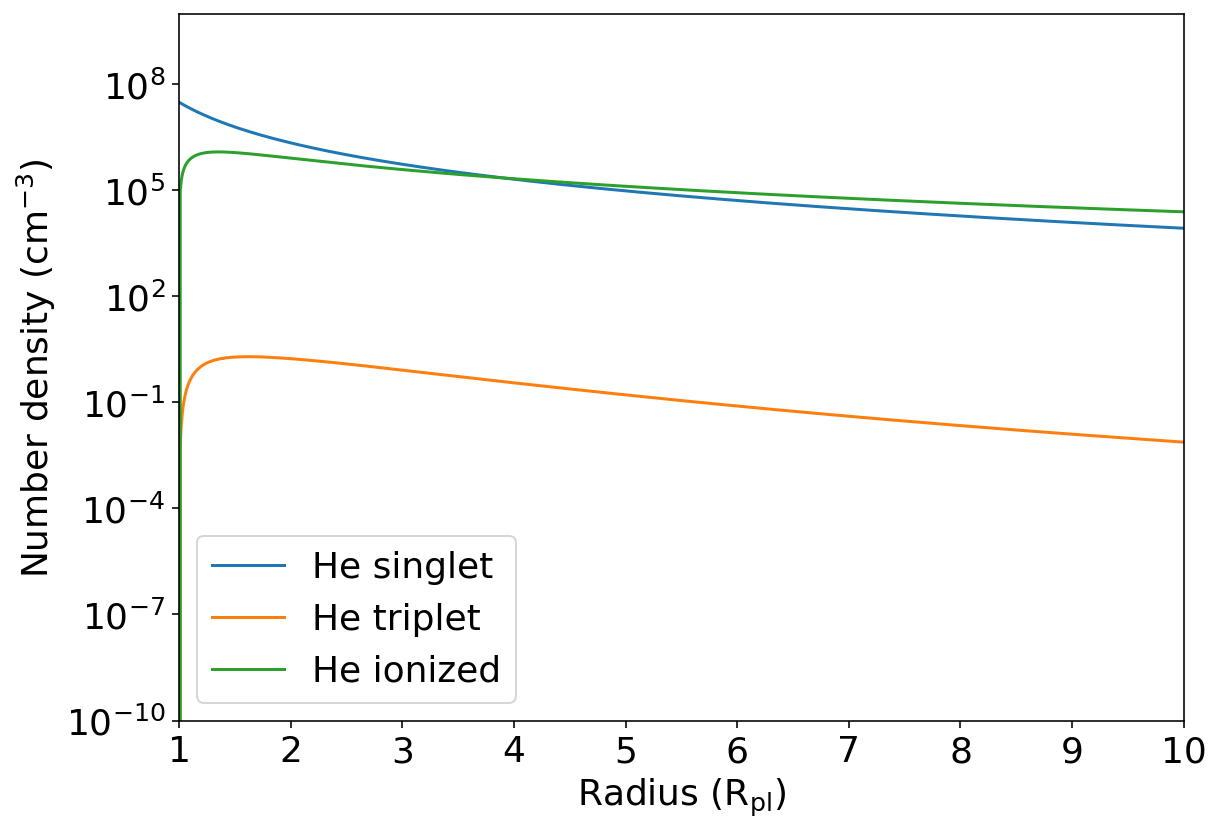

In [19]:
# Hydrogen atom mass
m_h = c.m_p.to(u.g).value

# Number density of helium nuclei 
he_fraction = 1 - h_fraction
n_he = (rho_array * rhos * he_fraction / (1 + 4 * he_fraction) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-10, 1E10)
plt.legend()
plt.show()

As you can see, the resulting structure and He number density profiles are significantly different than the ones from the [quickstart example](https://p-winds.readthedocs.io/en/latest/quickstart.html), so for HD 209458 b the tidal effects are very important. You can find more details about these effects in [Erkaev et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007A%26A...472..329E/abstract), [Murray-Clay et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...693...23M/abstract) and in Appendix E in [Vissapragada et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220411865V/abstract).

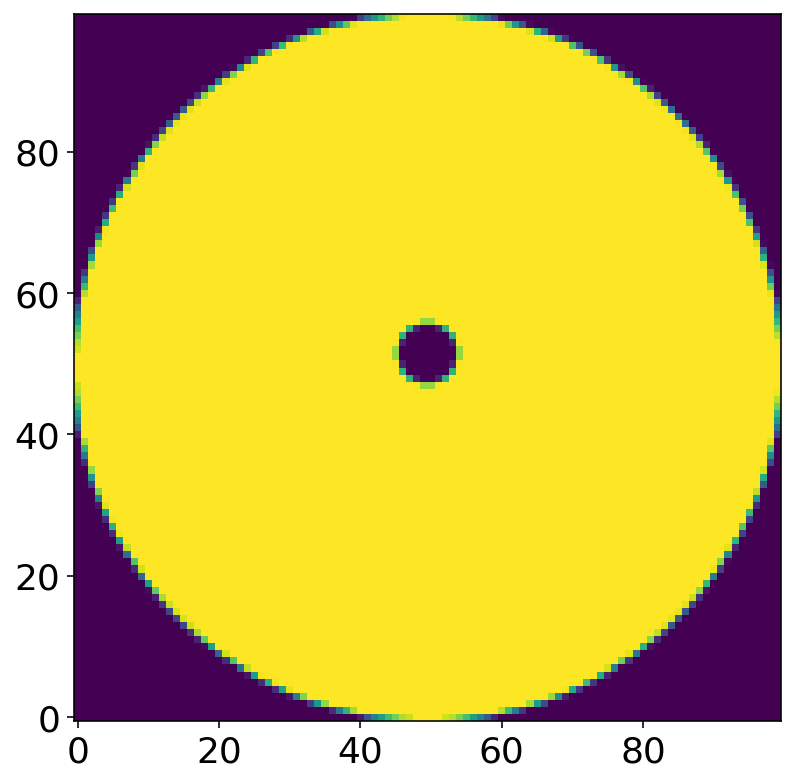

In [20]:
# First convert everything to SI units because they make our lives
# much easier.
R_pl_physical = R_pl * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
v_SI = v_array * vs * 1000  # Velocity of the outflow in m / s
n_he_3_SI = n_he_3 * 1E6  # Volumetric densities in 1 / m ** 3
planet_to_star_ratio = 0.0834

# Set up the ray tracing. We will use a coarse 100-px grid size,
# but we use supersampling to avoid hard pixel edges.
flux_map, t_depth, r_from_planet = transit.draw_transit(
    planet_to_star_ratio,
    planet_physical_radius=R_pl_physical,
    impact_parameter=impact_parameter,
    phase=0.0,
    supersampling=10,
    grid_size=100)

# And now we plot it just to check how the transit looks
plt.imshow(flux_map, origin='lower')
plt.show()

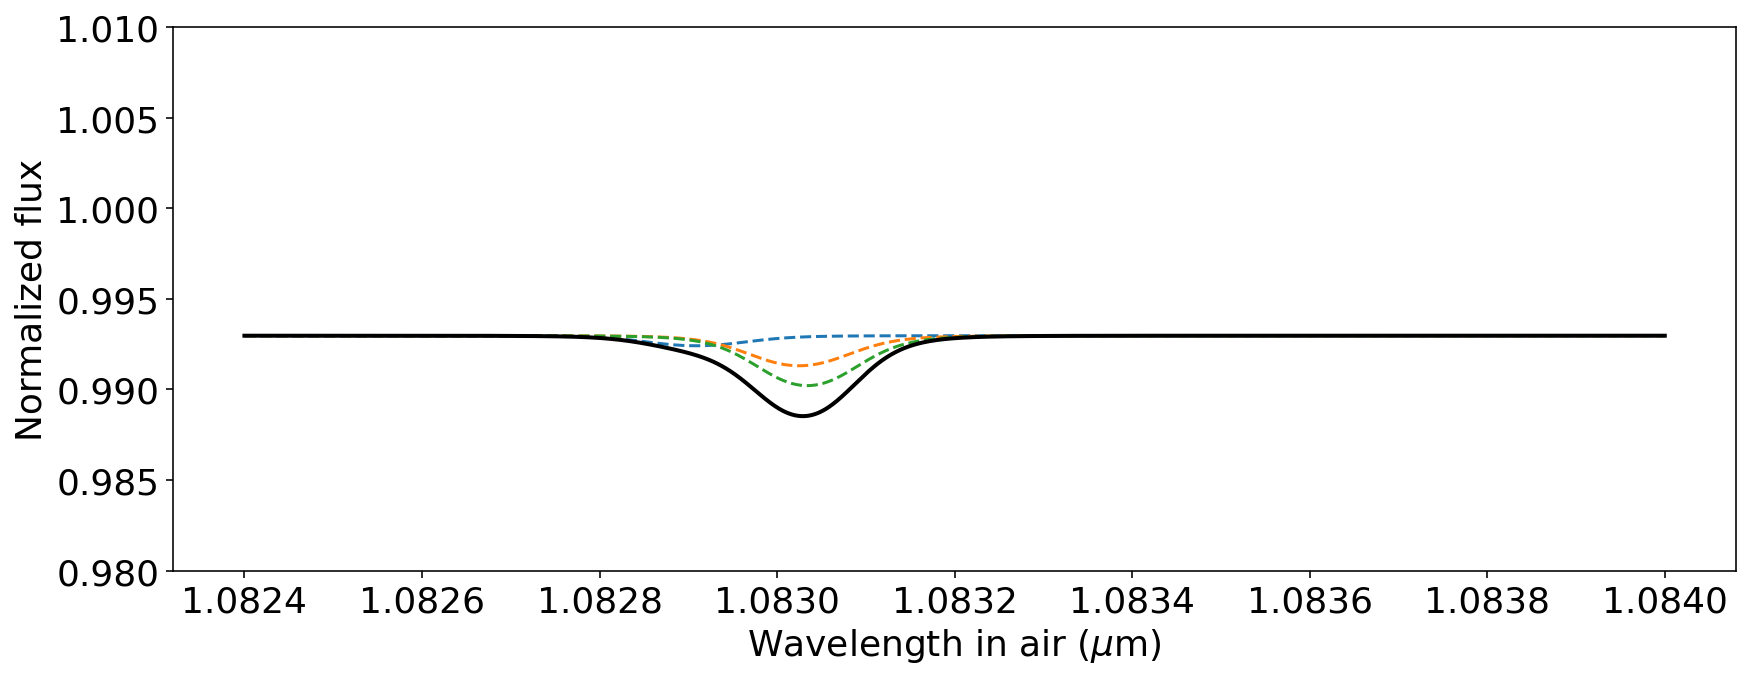

In [22]:
w0, w1, w2, f0, f1, f2, a_ij = lines.he_3_properties()

m_He = 4 * 1.67262192369e-27  # Helium atomic mass in kg
wl = np.linspace(1.0824, 1.0840, 1000) * 1E-6  # Wavelengths in m

# First, let's do the radiative transfer for each line of the triplet
# separately. Check the documentation to understand what are the
# input parameters, as there are many of them.

# Another important thing to have in mind is that the formal calculation
# of the radiative transfer can take a long time. To make it faster,
# there is an option that assumes something about the atmosphere
# and accelerates the modeling. That approximation is triggered by the
# `wind_broadening_method` input parameter set to `'average'`. If you want
# to do the formal calculation, set `wind_broadening_method` to `'formal'`.
# The default is `'average'`.
method = 'formal'

spectrum_0 = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w0, f0, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)
spectrum_1 = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w1, f1, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)
spectrum_2 = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w2, f2, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)

# Finally let's calculate the combined spectrum of all lines in the triplet
# To do that, we combine all the line properties in their respective arrays
w_array = np.array([w0, w1, w2])
f_array = np.array([f0, f1, f2])
a_array = np.array([a_ij, a_ij, a_ij])  # This is the same for all lines in then triplet
spectrum = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wl, T_0, m_He, wind_broadening_method=method)

plt.figure(figsize=(14,5))
plt.plot(wl * 1E6, spectrum_0, ls='--')
plt.plot(wl * 1E6, spectrum_1, ls='--')
plt.plot(wl * 1E6, spectrum_2, ls='--')
plt.plot(wl * 1E6, spectrum, color='k', lw=2)
plt.xlabel('Wavelength in air ($\mu$m)')
plt.ylabel('Normalized flux')
plt.ylim(0.98, 1.01)
plt.show()